In [1]:
import psycopg2
import pandas as pd
from tqdm import tqdm
import json
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Adjust width to avoid line wrapping
pd.set_option('display.max_colwidth', None)  # Display full content in each cell

In [2]:

host = "localhost"
port = "5432"

# PostgreSQL credentials
user = "tanmay"
password = "pass_postgre1"
database = "mimic4_clinical_demo"

# Connect to PostgreSQL
try:
    conn = psycopg2.connect(
        host=host,
        port=port,
        user=user,
        password=password,
        dbname=database
    )
    print("PSQL Connection successful!")
except Exception as e:
    print(f"Error connecting to database: {e}")

PSQL Connection successful!


In [3]:
# Execute Query
def exec_query(query):
    try:
        # Establish the connection
        conn = psycopg2.connect(
        host=host,
        port=port,
        user=user,
        password=password,
        dbname=database
        )
        cursor = conn.cursor()
        # Execute the query
        cursor.execute(query)
        # Fetch column names from the cursor
        colnames = [desc[0] for desc in cursor.description]
        # Fetch all rows of the query
        results = cursor.fetchall()
        # Create a DataFrame with column names
        df = pd.DataFrame(results, columns=colnames)
        # Close the cursor and connection
        cursor.close()
        conn.close()
        # Return the DataFrame
        return df

    except Exception as e:
        print(f"Error executing query: {e}")
        # Roll back the transaction in case of error
        conn.rollback()
        cursor.close()
        conn.close()
        return None

# Ventilator & Oxygen Needs Forecasting

# 1: Data Preparation

In [4]:

# 1. Extract ICU data
query_icustays = """
SELECT subject_id, hadm_id, intime, outtime, los, first_careunit, last_careunit
FROM icustays;
"""
icu_df = exec_query(query_icustays)
print("ICU Data:")
display(icu_df.head())

# 2. Extract Admissions data
query_admissions = """
SELECT subject_id, hadm_id, admittime, dischtime, admission_type
FROM admissions;
"""
adm_df = exec_query(query_admissions)
print("Admissions Data:")
display(adm_df.head())

# 3. Extract Diagnoses data (ICD codes)
query_diagnoses = """
SELECT subject_id, hadm_id, icd_code, seq_num
FROM diagnoses_icd;
"""
diag_df = exec_query(query_diagnoses)
print("Diagnoses Data:")
display(diag_df.head())

# 4. Extract ICD Descriptions for context
query_d_icd_diagnoses = """
SELECT icd_code, icd_version, long_title
FROM d_icd_diagnoses;
"""
diag_desc_df = exec_query(query_d_icd_diagnoses)
print("ICD Descriptions:")
display(diag_desc_df.head())


ICU Data:


,subject_id,hadm_id,intime,outtime,los,first_careunit,last_careunit
0,10020187,24104168,2169-01-15 04:56:00,2169-01-20 15:47:50,5.4526620370370367,Neuro Surgical Intensive Care Unit (Neuro SICU),Neuro Stepdown
1,10020187,26842957,2170-02-24 18:18:46,2170-02-25 15:15:26,0.87268518518518523,Neuro Intermediate,Neuro Intermediate
2,10012853,27882036,2176-11-26 02:34:49,2176-11-29 20:58:54,3.766724537037037,Trauma SICU (TSICU),Trauma SICU (TSICU)
3,10020740,25826145,2150-06-03 20:12:32,2150-06-04 21:05:58,1.0371064814814817,Trauma SICU (TSICU),Trauma SICU (TSICU)
4,10039708,23819016,2140-06-18 01:41:00,2140-06-19 21:47:16,1.8376851851851852,Trauma SICU (TSICU),Trauma SICU (TSICU)


Admissions Data:


,subject_id,hadm_id,admittime,dischtime,admission_type
0,10009628,25926192,2153-09-17 17:08:00,2153-09-25 13:20:00,URGENT
1,10018081,23983182,2134-08-18 02:02:00,2134-08-23 19:35:00,URGENT
2,10006053,22942076,2111-11-13 23:39:00,2111-11-15 17:20:00,URGENT
3,10031404,21606243,2113-08-04 18:46:00,2113-08-06 20:57:00,URGENT
4,10005817,20626031,2132-12-12 01:43:00,2132-12-20 15:04:00,URGENT


Diagnoses Data:


,subject_id,hadm_id,icd_code,seq_num
0,10035185,22580999,V707,10
1,10035185,22580999,41401,1
2,10035185,22580999,3899,9
3,10035185,22580999,V8532,11
4,10035185,22580999,25002,2


ICD Descriptions:


,icd_code,icd_version,long_title
0,01160,9,"Tuberculous pneumonia [any form], unspecified"
1,01186,9,"Other specified pulmonary tuberculosis, tubercle bacilli not found by bacteriological or histological examination, but tuberculosis confirmed by other methods [inoculation of animals]"
2,01200,9,"Tuberculous pleurisy, unspecified"
3,01236,9,"Tuberculous laryngitis, tubercle bacilli not found by bacteriological or histological examination, but tuberculosis confirmed by other methods [inoculation of animals]"
4,01525,9,"Tuberculosis of knee, tubercle bacilli not found by bacteriological examination, but tuberculosis confirmed histologically"


# 2: Preprocessing & Merge

In [5]:
# 1. Convert date/time columns to datetime format
icu_df['intime'] = pd.to_datetime(icu_df['intime'])
icu_df['outtime'] = pd.to_datetime(icu_df['outtime'])
adm_df['admittime'] = pd.to_datetime(adm_df['admittime'])
adm_df['dischtime'] = pd.to_datetime(adm_df['dischtime'])

# 2. Merge ICU and Admissions data on subject_id and hadm_id
icu_adm_df = pd.merge(icu_df, adm_df, on=['subject_id', 'hadm_id'], how='left')
print("Merged ICU & Admissions Data:")
display(icu_adm_df.head())

# 3. Merge Diagnoses data with ICD Descriptions to add detailed diagnosis info
diag_merged = pd.merge(diag_df, diag_desc_df, on='icd_code', how='left')
print("Merged Diagnoses Data:")
display(diag_merged.head())

# 4. Filter for respiratory-related diagnoses
# Define a list of keywords that indicate respiratory issues
resp_keywords = ["respiratory", "pulmonary", "pneumonia", "ARDS"]
pattern = "|".join(resp_keywords)

# Filter rows where the diagnosis description (long_title) contains one of these keywords (case-insensitive)
resp_diag = diag_merged[diag_merged['long_title'].str.contains(pattern, case=False, na=False)]
print("Respiratory Diagnoses Data:")
display(resp_diag.head())

# 5. Merge the filtered respiratory diagnoses with the ICU & Admissions data
icu_adm_diag = pd.merge(icu_adm_df, resp_diag, on=['subject_id', 'hadm_id'], how='inner')
print("ICU Admissions with Respiratory Diagnoses:")
display(icu_adm_diag.head())

Merged ICU & Admissions Data:


,subject_id,hadm_id,intime,outtime,los,first_careunit,last_careunit,admittime,dischtime,admission_type
0,10020187,24104168,2169-01-15 04:56:00,2169-01-20 15:47:50,5.4526620370370367,Neuro Surgical Intensive Care Unit (Neuro SICU),Neuro Stepdown,2169-01-15 04:04:00,2169-01-24 17:20:00,OBSERVATION ADMIT
1,10020187,26842957,2170-02-24 18:18:46,2170-02-25 15:15:26,0.87268518518518523,Neuro Intermediate,Neuro Intermediate,2170-02-24 00:00:00,2170-02-25 15:00:00,SURGICAL SAME DAY ADMISSION
2,10012853,27882036,2176-11-26 02:34:49,2176-11-29 20:58:54,3.766724537037037,Trauma SICU (TSICU),Trauma SICU (TSICU),2176-11-25 21:28:00,2176-12-03 15:24:00,EW EMER.
3,10020740,25826145,2150-06-03 20:12:32,2150-06-04 21:05:58,1.0371064814814817,Trauma SICU (TSICU),Trauma SICU (TSICU),2150-06-03 20:12:00,2150-06-07 15:05:00,EW EMER.
4,10039708,23819016,2140-06-18 01:41:00,2140-06-19 21:47:16,1.8376851851851852,Trauma SICU (TSICU),Trauma SICU (TSICU),2140-06-18 00:22:00,2140-06-22 17:40:00,OBSERVATION ADMIT


Merged Diagnoses Data:


,subject_id,hadm_id,icd_code,seq_num,icd_version,long_title
0,10035185,22580999,V707,10,9,Examination of participant in clinical trial
1,10035185,22580999,V707,10,10,Person on outside of bus injured in collision with pedestrian or animal in traffic accident
2,10035185,22580999,41401,1,9,Coronary atherosclerosis of native coronary artery
3,10035185,22580999,3899,9,9,Unspecified hearing loss
4,10035185,22580999,V8532,11,9,"Body Mass Index 32.0-32.9, adult"


Respiratory Diagnoses Data:


,subject_id,hadm_id,icd_code,seq_num,icd_version,long_title
11,10009049,22995465,4829,2,9,"Bacterial pneumonia, unspecified"
39,10014729,23300884,V151,8,9,"Personal history of surgery to heart and great vessels, presenting hazards to health"
60,10001217,24597018,5180,4,9,Pulmonary collapse
92,10022017,22342963,J810,2,10,Acute pulmonary edema
194,10020640,27984218,486,1,9,"Pneumonia, organism unspecified"


ICU Admissions with Respiratory Diagnoses:


,subject_id,hadm_id,intime,outtime,los,first_careunit,last_careunit,admittime,dischtime,admission_type,icd_code,seq_num,icd_version,long_title
0,10012853,27882036,2176-11-26 02:34:49,2176-11-29 20:58:54,3.766724537037037,Trauma SICU (TSICU),Trauma SICU (TSICU),2176-11-25 21:28:00,2176-12-03 15:24:00,EW EMER.,J398,17,10,Other specified diseases of upper respiratory tract
1,10012853,27882036,2176-11-26 02:34:49,2176-11-29 20:58:54,3.766724537037037,Trauma SICU (TSICU),Trauma SICU (TSICU),2176-11-25 21:28:00,2176-12-03 15:24:00,EW EMER.,J9622,7,10,Acute and chronic respiratory failure with hypercapnia
2,10012853,27882036,2176-11-26 02:34:49,2176-11-29 20:58:54,3.766724537037037,Trauma SICU (TSICU),Trauma SICU (TSICU),2176-11-25 21:28:00,2176-12-03 15:24:00,EW EMER.,J9621,2,10,Acute and chronic respiratory failure with hypoxia
3,10012853,27882036,2176-11-26 02:34:49,2176-11-29 20:58:54,3.766724537037037,Trauma SICU (TSICU),Trauma SICU (TSICU),2176-11-25 21:28:00,2176-12-03 15:24:00,EW EMER.,J449,5,10,"Chronic obstructive pulmonary disease, unspecified"
4,10012853,27882036,2176-11-26 02:34:49,2176-11-29 20:58:54,3.766724537037037,Trauma SICU (TSICU),Trauma SICU (TSICU),2176-11-25 21:28:00,2176-12-03 15:24:00,EW EMER.,Z86711,28,10,Personal history of pulmonary embolism


# 3: Feature Engineering

In [7]:

# 1. Calculate ICU length of stay in hours
# Convert 'los' column to float
icu_adm_diag['los'] = pd.to_numeric(icu_adm_diag['los'], errors='coerce')

# Now compute ICU length of stay in hours
icu_adm_diag['icu_los_hours'] = icu_adm_diag['los'] * 24

# Create a dummy target variable for ventilator need: if ICU LOS > 72 hours, flag as 1, else 0.
icu_adm_diag['ventilator_needed'] = icu_adm_diag['icu_los_hours'].apply(lambda x: 1 if x > 72 else 0)

# Display the engineered features
print("Engineered Features:")
print(icu_adm_diag[['subject_id', 'hadm_id', 'icu_los_hours', 'ventilator_needed']].head())

Engineered Features:
  subject_id   hadm_id  icu_los_hours  ventilator_needed
0   10012853  27882036      90.401389                  1
1   10012853  27882036      90.401389                  1
2   10012853  27882036      90.401389                  1
3   10012853  27882036      90.401389                  1
4   10012853  27882036      90.401389                  1


# 4: Model Building & Evaluation

In [9]:

# 1. Deduplicate the data to have one record per (subject_id, hadm_id)
model_df = icu_adm_diag.drop_duplicates(subset=['subject_id', 'hadm_id'])

# 2. Prepare features and target variable
X = model_df[['icu_los_hours']]    # Using ICU LOS (in hours) as the sole feature
y = model_df['ventilator_needed']    # Target variable

# 3. Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 4. Build and train a Logistic Regression model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

# 5. Make predictions on the test set
y_pred = model.predict(X_test)

# 6. Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        11

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19

Confusion Matrix:
[[ 8  0]
 [ 0 11]]


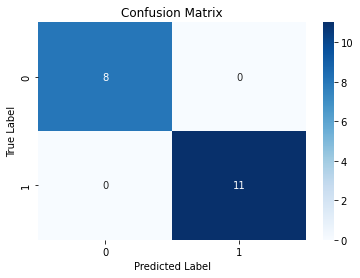

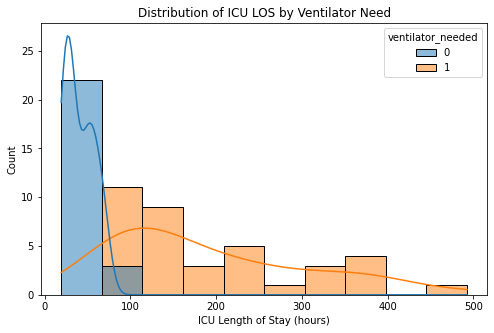

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Plot the Confusion Matrix as a heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 2. Plot the distribution of ICU Length of Stay by ventilator need
plt.figure(figsize=(8, 5))
sns.histplot(data=model_df, x="icu_los_hours", hue="ventilator_needed", bins=10, kde=True)
plt.xlabel("ICU Length of Stay (hours)")
plt.title("Distribution of ICU LOS by Ventilator Need")
plt.show()
